# **SLDS Lorenz YZ**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time as time
import random 
import reservoirpy.datasets as rsvp_d
import os

from scipy.special import logsumexp
from scipy.stats import multivariate_normal, invwishart, matrix_normal

## Data generation

In [2]:
def Plot2D(xs, ys, zs, titl1, titl2, titl3, start, pt_number, lw = 1, figsize = (15, 5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = figsize)

    ax1.plot(xs[start:start+pt_number], ys[start:start+pt_number], lw=lw)
    ax1.set_title(titl1)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")

    ax2.plot(xs[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax2.set_title(titl2)
    ax2.set_xlabel("X Axis")
    ax2.set_ylabel("Z Axis")

    ax3.plot(ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax3.set_title(titl3)
    ax3.set_xlabel("Y Axis")
    ax3.set_ylabel("Z Axis")

    plt.tight_layout()
    plt.show()

def Plot3D(xs, ys, zs, title, start, pt_number, lw = 1, figsize = (15, 5)):
    ax = plt.figure(figsize = figsize).add_subplot(projection='3d')
    ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()
    
def coordinate_choice(attractor, xxn, yyn, zzn):
    match attractor:
        case "Lorenz":
            x = xxn
        case "Rossler":
            x = zzn
    return x

In [3]:
def loader(attractor, path, formatt, save, **kwargs):
    match attractor:
        case "Lorenz":
            name = "Lorenz_rho_%s_sigma_%s_beta_%s_x_%s_y_%s_z_%s_h_%s_method_%s_rtol_%s_atol_%s_n_%s" % (kwargs["params"][0], kwargs["params"][1], kwargs["params"][2],
                                                                                                         kwargs["x0"][0], kwargs["x0"][1], kwargs["x0"][2],
                                                                                                         kwargs["h"], kwargs["method"], kwargs["rtol"], kwargs["atol"], kwargs["n"])
            name = path + name + formatt
        case "Rossler":
            name = "Rossler_a_%s_b_%s_c_%s_x_%s_y_%s_z_%s_h_%s_method_%s_rtol_%s_atol_%s_n_%s" % (kwargs["params"][0], kwargs["params"][1], kwargs["params"][2],
                                                                                                         kwargs["x0"][0], kwargs["x0"][1], kwargs["x0"][2],
                                                                                                         kwargs["h"], kwargs["method"], kwargs["rtol"], kwargs["atol"], kwargs["n"])
            name = path + name + formatt
    print("filename:\t", name)
    if not os.path.exists(name):
        print('file not found, proceding with computation')
        t1 = time.time() #times the computation
        match attractor:
            case "Lorenz":
                dataset = rsvp_d.lorenz(kwargs["n"], rho=kwargs["params"][0], sigma=kwargs["params"][1], beta=kwargs["params"][2], 
                                        x0=kwargs["x0"], h=kwargs["h"], method=kwargs["method"], rtol = kwargs["rtol"], atol = np.ones(3)*kwargs["atol"])
            case "Rossler":
                dataset = rsvp_d.rossler(kwargs["n"], a=kwargs["params"][0], b=kwargs["params"][1], c=kwargs["params"][2], 
                                        x0=kwargs["x0"], h=kwargs["h"], method=kwargs["method"], rtol = kwargs["rtol"], atol = np.ones(3)*kwargs["atol"])
        dt = time.time() - t1#times the computation
        print('computation took ', dt,' seconds.')
        dataset = np.array(dataset).T
        if save:
            match formatt:
                case ".npy":
                    np.save(name, dataset)
                case ".csv":
                    np.savetxt(name, dataset, delimiter = " ", header = "")
            print("file saved")
    else:
        print("file correctly loaded")
        match formatt:
            case ".npy":
                dataset = np.load(name)
            case ".csv":
                dataset = np.loadtxt(name)
    return dataset

filename:	 ./data/Lorenz_rho_28_sigma_10_beta_2.6666666666666665_x_0.0_y_0.5_z_20.0_h_0.01_method_DOP853_rtol_1e-13_atol_1e-100_n_10000.0.npy
file correctly loaded


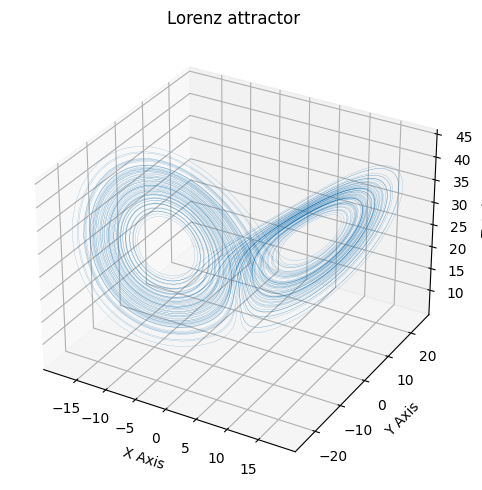

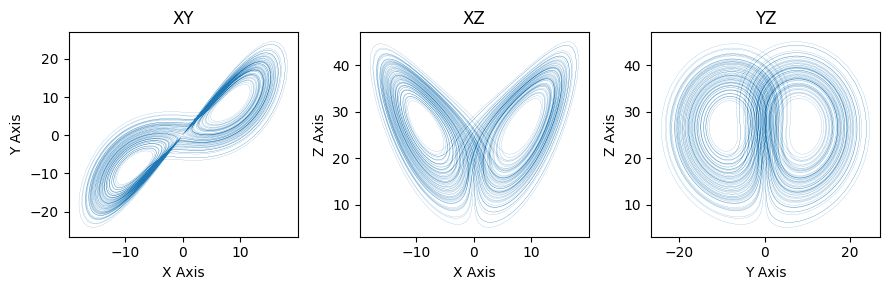

In [4]:
# Data generation parameters
attractor = "Lorenz"
path = "./data/"
n = 1e4
params = [28, 10, 8/3]
x0 = [0.0, 0.5, 20.0]
method = 'DOP853'
rtol = 1e-13
atol = 1e-100
h = 0.01
noise_amplitude = 1e-3
arr = loader(attractor = attractor, path = path, formatt = ".npy", save = True, n = n, params = params, x0 = x0, h = h, method = method, rtol = rtol, atol = atol).T
#-------------------------------------------

noise = np.random.normal(loc=0.0, scale=noise_amplitude, size=None)
xxn, yyn, zzn = arr[:,0], arr[:,1], arr[:,2]
dt = h
N = n
ttn = dt*(np.arange(N) + 1)

Plot3D(xxn, yyn, zzn, str(attractor)+ " attractor", start=0, pt_number=int(n), lw = .1, figsize = (5, 5))
Plot2D(xxn, yyn, zzn, "XY", "XZ", "YZ", start=0, pt_number=int(n), lw = .1, figsize = (9, 3))

plt.show()

In [5]:
y = arr[0:2000,1:3]/25
y[:, 1] = (y[:, 1] - 1)*1.2
y.shape

(2000, 2)

(-1.0, 1.0)

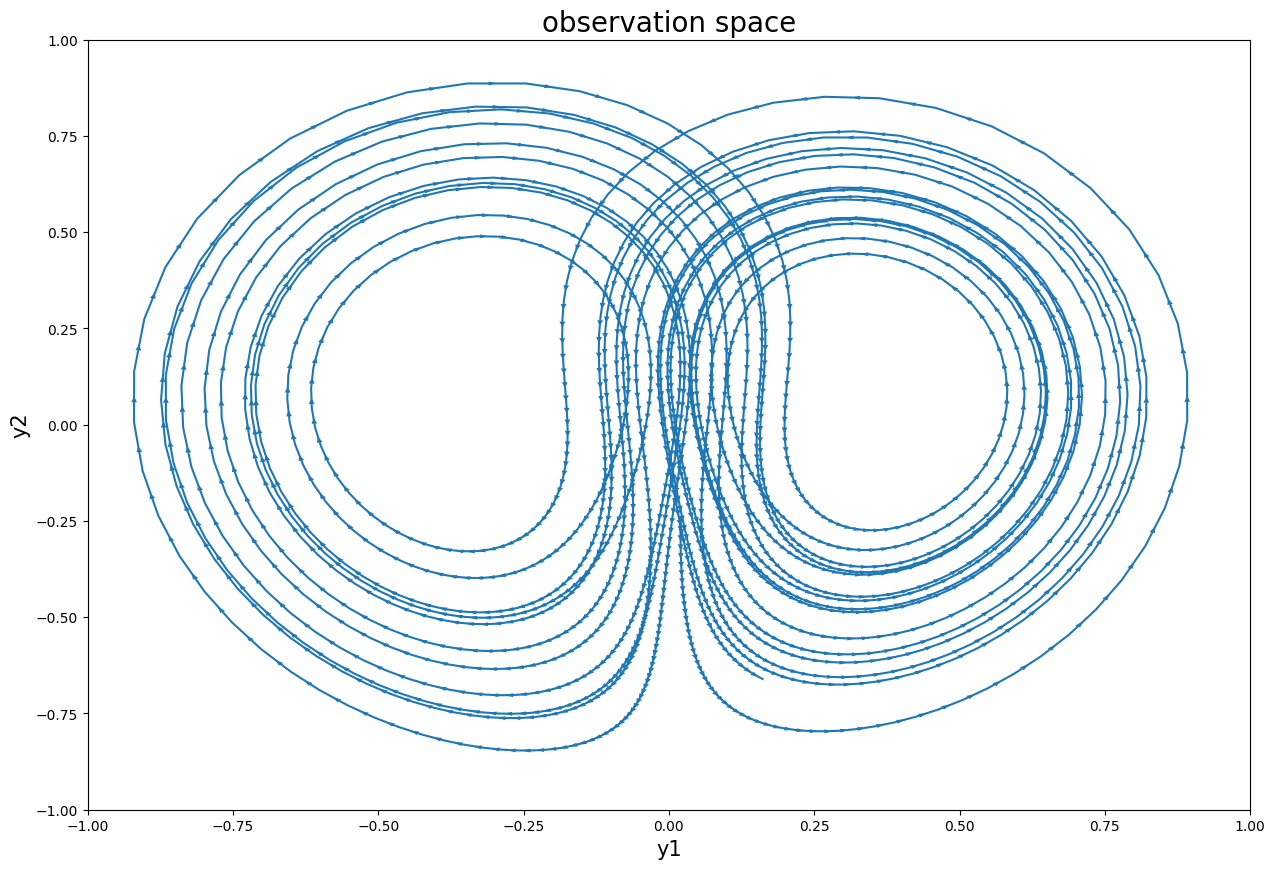

In [6]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1])

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [7]:
def plot_latent_state_dynamic(X1, X2, A, b, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 6*K))
    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        if show_fixed_point:
            ax[k].scatter(x_star[k][0], x_star[k][1])

        if show_states:
            c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else i for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, 0], y[t:t+2, 1], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
            '''
            # code to add the arrows in the middle of the lines (fix head_width if needed)
            for t in range(y.shape[0]-1):
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = 'navy')
            '''
            

In [8]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [9]:
T = y.shape[0] # number of time steps
N = 2 # observation dim
K = 3 # latent dim

L = 40 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

#S = generate_random_semipositive_matrix(N, 1)
S = 0.0001*np.eye(N, N)
nu = N
C = 0.1*np.random.randn(N, N+1)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 0.1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0] = 1*np.random.randn(K, N, N+1)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([0.0001*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[-1.41419085 -1.2696084   0.88157794]
  [-2.67989593 -0.68769464 -0.88345423]]

 [[ 1.67159777  0.74486245 -0.21440642]
  [ 1.12028888 -0.58563234  0.83671416]]

 [[-0.06765356 -0.2637078  -1.11928422]
  [-1.91017359 -1.33774172 -0.15293903]]]


In [10]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

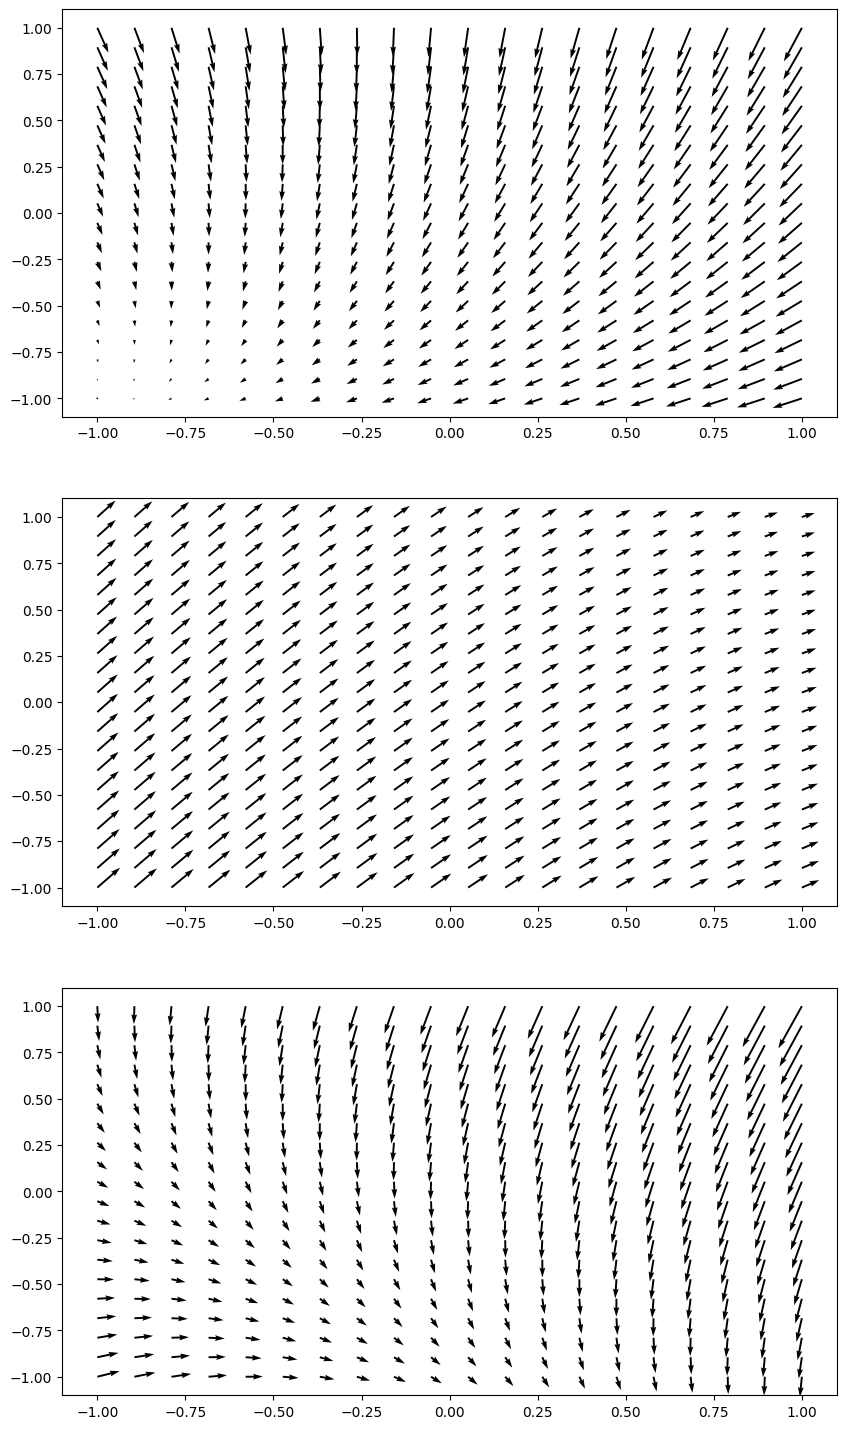

In [11]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf, b_inf, show_fixed_point = False)

In [12]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [13]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)


 SAMPLE: 0

 SAMPLE: 1

 SAMPLE: 2

 SAMPLE: 3

 SAMPLE: 4

 SAMPLE: 5

 SAMPLE: 6

 SAMPLE: 7

 SAMPLE: 8

 SAMPLE: 9

 SAMPLE: 10

 SAMPLE: 11

 SAMPLE: 12

 SAMPLE: 13

 SAMPLE: 14

 SAMPLE: 15

 SAMPLE: 16

 SAMPLE: 17

 SAMPLE: 18

 SAMPLE: 19

 SAMPLE: 20

 SAMPLE: 21

 SAMPLE: 22

 SAMPLE: 23

 SAMPLE: 24

 SAMPLE: 25

 SAMPLE: 26

 SAMPLE: 27

 SAMPLE: 28

 SAMPLE: 29

 SAMPLE: 30

 SAMPLE: 31

 SAMPLE: 32

 SAMPLE: 33

 SAMPLE: 34

 SAMPLE: 35

 SAMPLE: 36

 SAMPLE: 37

 SAMPLE: 38


In [14]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[50:], return_counts=True)
print(dict(zip(unique, counts)))

[2 1 0 ... 1 1 0]
[1 2 2 ... 2 2 2]
[1 1 1 ... 1 1 1]
[0.9   1.15  1.125 ... 1.1   1.1   1.075]
{}


In [15]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.35834682 0.36417191 0.27748127]
 [0.00355778 0.98367854 0.01276367]
 [0.00479686 0.02808784 0.9671153 ]]
[ 1.33407382e+15 -7.45592869e+14 -5.88480952e+14]


In [16]:
print(np.mean(A_hat_inf, axis = 0))

[[[-6.43770391e-04  5.25239045e-02  1.76597374e-01]
  [-1.08380230e-01 -6.74167734e-02  2.84852145e-02]]

 [[ 3.92762672e-02  9.89811397e-01 -6.08625419e-02]
  [-1.25607228e-02  1.33207809e-01  9.91529364e-01]]

 [[ 7.00553370e-03  9.72572444e-01  2.45857912e-02]
  [-8.53862447e-02 -1.80519643e-01  9.64164855e-01]]]


In [17]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[ 0.00400609 -0.00036829]
 [-0.00036829  0.00801636]]
[0.00397255 0.0080499 ]
[[ 2.39692474e-04 -2.09211336e-05]
 [-2.09211336e-05  1.81269383e-04]]
[0.00024641 0.00017455]
[[3.21820695e-04 3.69094847e-05]
 [3.69094847e-05 2.37347159e-04]]
[0.00033568 0.00022349]


In [18]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

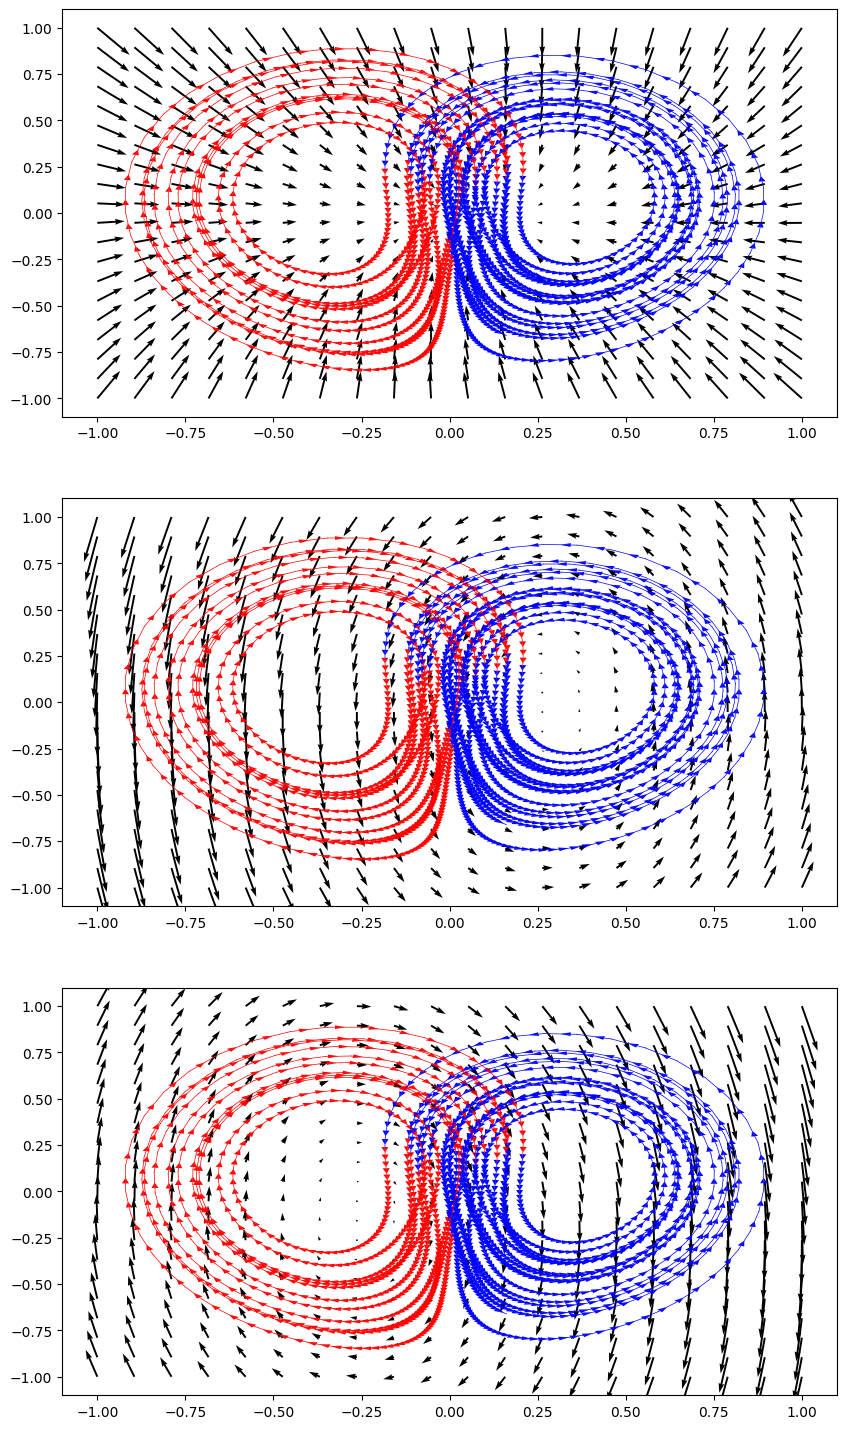

In [19]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, show_fixed_point = False, show_states = True, z = z_inf[10])